In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime

## Carga de CSVs

In [2]:
dfEstaciones =pd.read_csv('CSVs/station.csv', thousands=',', low_memory=False)
dfClima=pd.read_csv('CSVs/weather.csv', thousands=',', low_memory=False)
dfViajes = pd.read_csv('CSVs/trip.csv', thousands=',', low_memory=False)

In [3]:
chunksize = 10 ** 2
dfStatus = pd.read_csv('CSVs/status.csv', chunksize=chunksize, iterator=True)
print dfStatus.get_chunk(4)

   station_id  bikes_available  docks_available                 time
0           2                2               25  2013/08/29 12:06:01
1           2                2               25  2013/08/29 12:07:01
2           2                2               25  2013/08/29 12:08:01
3           2                2               25  2013/08/29 12:09:01


# Analisis de dfEstaciones

In [68]:
dfEstaciones

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013


In [110]:
dfEstaciones.tail()

,id,name,lat,long,dock_count,city,installation_date
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014
69,84,Ryland Park,37.342725,-121.895617,15,San Jose,4/9/2014


In [70]:
dfEstaciones.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [111]:
print (dfEstaciones.shape) #es cortito

(70, 7)


In [112]:
dfEstaciones.installation_date = pd.to_datetime(dfEstaciones.installation_date, format = "%m/%d/%Y").dt.date

#The min date is before any in the train data frame, therefore stations were installed before the first trips (good).
#The max date is before the end of the train data frame, therefore the service has not been adding new stations recently.
print (dfEstaciones.installation_date.min())
print (dfEstaciones.installation_date.max())

2013-08-05
2014-04-09


# Analisis de dfClima

In [69]:
dfClima

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74,68,61,61,58,56,93,75,57,...,10,10,23,11,28,0,4,NaN,286,94107
1,8/30/2013,78,69,60,61,58,56,90,70,50,...,10,7,29,13,35,0,2,NaN,291,94107
2,8/31/2013,71,64,57,57,56,54,93,75,57,...,10,10,26,15,31,0,4,NaN,284,94107
3,9/1/2013,74,66,58,60,56,53,87,68,49,...,10,10,25,13,29,0,4,NaN,284,94107
4,9/2/2013,75,69,62,61,60,58,93,77,61,...,10,6,23,12,30,0,6,NaN,277,94107
5,9/3/2013,73,67,60,59,56,51,84,65,46,...,10,10,24,15,31,0,2,NaN,276,94107
6,9/4/2013,74,68,61,59,57,56,90,72,53,...,10,10,29,19,35,0,4,NaN,269,94107
7,9/5/2013,72,66,60,57,56,54,90,74,57,...,10,10,31,21,37,0,3,NaN,270,94107
8,9/6/2013,85,71,56,57,51,45,86,58,29,...,10,10,24,8,28,0,0,NaN,287,94107
9,9/7/2013,88,73,58,64,54,46,86,59,31,...,10,10,21,8,25,0,1,NaN,305,94107


In [72]:
dfClima.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

# Analisis de dfViajes

In [71]:
dfViajes.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [73]:
dfViajes

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103
5,4927,103,8/29/2013 18:54,Golden Gate at Polk,59,8/29/2013 18:56,Golden Gate at Polk,59,527,Subscriber,94109
6,4500,109,8/29/2013 13:25,Santa Clara at Almaden,4,8/29/2013 13:27,Adobe on Almaden,5,679,Subscriber,95112
7,4563,111,8/29/2013 14:02,San Salvador at 1st,8,8/29/2013 14:04,San Salvador at 1st,8,687,Subscriber,95112
8,4760,113,8/29/2013 17:01,South Van Ness at Market,66,8/29/2013 17:03,South Van Ness at Market,66,553,Subscriber,94103
9,4258,114,8/29/2013 11:33,San Jose City Hall,10,8/29/2013 11:35,MLK Library,11,107,Subscriber,95060


## Analisis de duracion de viajes

In [74]:
dfViajes.duration.describe()

count      669959.000000
mean         1107.949846
std         22255.437020
min            60.000000
25%           344.000000
50%           517.000000
75%           755.000000
max      17270400.000000
Name: duration, dtype: float64

### Obtengamos duracion en minutos

In [75]:
dfViajes.duration /=60

In [76]:
dfViajes.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

### Obtenemos cantidad de viajes

In [77]:
dfViajes.shape

(669959, 11)

Cantidad de viajes: 669959

### Chequeo de tipos de la informacion 

In [78]:
dfViajes.dtypes

id                      int64
duration              float64
start_date             object
start_station_name     object
start_station_id        int64
end_date               object
end_station_name       object
end_station_id          int64
bike_id                 int64
subscription_type      object
zip_code               object
dtype: object

In [79]:
#Convierto a DATETIME
dfViajes.start_date = pd.to_datetime(dfViajes.start_date, format='%m/%d/%Y %H:%M')

In [80]:
#Extract the year, month, and day from start_date
#Agrego el feature date
dfViajes['date'] = dfViajes.start_date.dt.date

In [81]:
dfViajes

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29
1,4607,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138,2013-08-29
2,4130,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29
3,4251,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060,2013-08-29
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103,2013-08-29
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,8/29/2013 18:56,Golden Gate at Polk,59,527,Subscriber,94109,2013-08-29
6,4500,1.816667,2013-08-29 13:25:00,Santa Clara at Almaden,4,8/29/2013 13:27,Adobe on Almaden,5,679,Subscriber,95112,2013-08-29
7,4563,1.850000,2013-08-29 14:02:00,San Salvador at 1st,8,8/29/2013 14:04,San Salvador at 1st,8,687,Subscriber,95112,2013-08-29
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,8/29/2013 17:03,South Van Ness at Market,66,553,Subscriber,94103,2013-08-29
9,4258,1.900000,2013-08-29 11:33:00,San Jose City Hall,10,8/29/2013 11:35,MLK Library,11,107,Subscriber,95060,2013-08-29


In [82]:
#Each entry in the date feature is a trip. 
#By finding the total number of times a date is listed, we know how many trips were taken on that date.
dates = {}
for d in dfViajes.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

# Creacion de dataframe general de estudio
#### considerese poner un mejor titulo a esto jajaj

In [136]:
#Create the data frame that will be used for training with the dictionary we just created.
dfCantViajes = pd.DataFrame.from_dict(dates, orient = "index")
dfCantViajes['date'] = dfCantViajes.index
dfCantViajes['viajes'] = dfCantViajes.ix[:,0]
Turi = dfCantViajes.ix[:,1:3]
Turi = Turi.sort_values('date') #Ordeno por fecha
Turi.reset_index(drop = True, inplace = True) # Queda mas prolijo con indice de 0 a ...
Turi

,date,viajes
0,2013-08-29,748
1,2013-08-30,714
2,2013-08-31,640
3,2013-09-01,706
4,2013-09-02,661
5,2013-09-03,597
6,2013-09-04,606
7,2013-09-05,677
8,2013-09-06,814
9,2013-09-07,796


In [84]:
print((dfCantViajes).info()) #todo ok

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 2015-07-26 to 2014-01-29
Data columns (total 3 columns):
0         733 non-null int64
date      733 non-null object
viajes    733 non-null int64
dtypes: int64(2), object(1)
memory usage: 22.9+ KB
None


In [85]:
print((dfViajes).info()) #todo ok


<class 'pandas.core.frame.DataFrame'>
Int64Index: 669959 entries, 0 to 669958
Data columns (total 12 columns):
id                    669959 non-null int64
duration              669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null object
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
date                  669959 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 66.4+ MB
None


In [86]:
dfViajes.groupby('start_station_id').get_group(10) #Queria ver si podia agrupar las estaciones


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date
1,4607,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138,2013-08-29
3,4251,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060,2013-08-29
9,4258,1.900000,2013-08-29 11:33:00,San Jose City Hall,10,8/29/2013 11:35,MLK Library,11,107,Subscriber,95060,2013-08-29
16,4242,2.350000,2013-08-29 11:25:00,San Jose City Hall,10,8/29/2013 11:27,San Jose City Hall,10,26,Subscriber,95060,2013-08-29
43,4606,3.183333,2013-08-29 14:38:00,San Jose City Hall,10,8/29/2013 14:42,San Jose City Hall,10,35,Subscriber,95138,2013-08-29
126,4822,5.716667,2013-08-29 17:37:00,San Jose City Hall,10,8/29/2013 17:43,San Pedro Square,6,196,Subscriber,95138,2013-08-29
152,4204,6.300000,2013-08-29 11:06:00,San Jose City Hall,10,8/29/2013 11:13,San Jose City Hall,10,28,Subscriber,95136,2013-08-29
163,4347,6.483333,2013-08-29 12:15:00,San Jose City Hall,10,8/29/2013 12:21,San Pedro Square,6,146,Subscriber,95112,2013-08-29
613,4160,21.183333,2013-08-29 10:42:00,San Jose City Hall,10,8/29/2013 11:03,San Jose City Hall,10,680,Subscriber,95112,2013-08-29
614,4164,21.266667,2013-08-29 10:47:00,San Jose City Hall,10,8/29/2013 11:09,San Jose City Hall,10,30,Subscriber,95060,2013-08-29


# Analisis de dfClima

In [87]:
dfClima.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [88]:
dfClima.date = pd.to_datetime(dfClima.date, format='%m/%d/%Y')

In [89]:
dfClima.head(10)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74,68,61,61,58,56,93,75,57,...,10,10,23,11,28,0,4,NaN,286,94107
1,2013-08-30,78,69,60,61,58,56,90,70,50,...,10,7,29,13,35,0,2,NaN,291,94107
2,2013-08-31,71,64,57,57,56,54,93,75,57,...,10,10,26,15,31,0,4,NaN,284,94107
3,2013-09-01,74,66,58,60,56,53,87,68,49,...,10,10,25,13,29,0,4,NaN,284,94107
4,2013-09-02,75,69,62,61,60,58,93,77,61,...,10,6,23,12,30,0,6,NaN,277,94107
5,2013-09-03,73,67,60,59,56,51,84,65,46,...,10,10,24,15,31,0,2,NaN,276,94107
6,2013-09-04,74,68,61,59,57,56,90,72,53,...,10,10,29,19,35,0,4,NaN,269,94107
7,2013-09-05,72,66,60,57,56,54,90,74,57,...,10,10,31,21,37,0,3,NaN,270,94107
8,2013-09-06,85,71,56,57,51,45,86,58,29,...,10,10,24,8,28,0,0,NaN,287,94107
9,2013-09-07,88,73,58,64,54,46,86,59,31,...,10,10,21,8,25,0,1,NaN,305,94107


In [90]:
dfClima

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74,68,61,61,58,56,93,75,57,...,10,10,23,11,28,0,4,NaN,286,94107
1,2013-08-30,78,69,60,61,58,56,90,70,50,...,10,7,29,13,35,0,2,NaN,291,94107
2,2013-08-31,71,64,57,57,56,54,93,75,57,...,10,10,26,15,31,0,4,NaN,284,94107
3,2013-09-01,74,66,58,60,56,53,87,68,49,...,10,10,25,13,29,0,4,NaN,284,94107
4,2013-09-02,75,69,62,61,60,58,93,77,61,...,10,6,23,12,30,0,6,NaN,277,94107
5,2013-09-03,73,67,60,59,56,51,84,65,46,...,10,10,24,15,31,0,2,NaN,276,94107
6,2013-09-04,74,68,61,59,57,56,90,72,53,...,10,10,29,19,35,0,4,NaN,269,94107
7,2013-09-05,72,66,60,57,56,54,90,74,57,...,10,10,31,21,37,0,3,NaN,270,94107
8,2013-09-06,85,71,56,57,51,45,86,58,29,...,10,10,24,8,28,0,0,NaN,287,94107
9,2013-09-07,88,73,58,64,54,46,86,59,31,...,10,10,21,8,25,0,1,NaN,305,94107


In [91]:
dfClima.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [92]:
#Limpio los datos bugeados, lo que no tiene nada lo pasamos a Normal
dfClima.loc[dfClima.events == 'rain', 'events'] = "Rain"
dfClima.loc[dfClima.events.isnull(), 'events'] = "Normal"

In [93]:
#Esto lo vi de un kernel de kaggle, en ningun lado encontre que es el feature zip_code


#It seems we have one entry per zip code
dfClima.zip_code.unique()



array([94107, 94063, 94301, 94041, 95113])

In [94]:
#Let's see which zip code has the cleanest date.
for zc in dfClima.zip_code.unique():
    print (dfClima[dfClima.zip_code == zc].isnull().sum())
    print ()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
events                             0
wind_dir_degrees                   0
zip_code                           0
dtype: int64
()
date                                0
max_temperature_f                   0
mean_temperature_f  

In [95]:
#Labura con el zip_code == 94107, es el mas 'limpio'
dfClimaLimpio = dfClima[dfClima.zip_code == 94107]

In [96]:
dfClimaLimpio.events

0                  Normal
1                  Normal
2                  Normal
3                  Normal
4                  Normal
5                  Normal
6                  Normal
7                  Normal
8                  Normal
9                  Normal
10                 Normal
11                 Normal
12                 Normal
13                 Normal
14                    Fog
15                 Normal
16                 Normal
17                 Normal
18                 Normal
19                 Normal
20                 Normal
21                 Normal
22                 Normal
23                   Rain
24                 Normal
25                 Normal
26                 Normal
27                 Normal
28                 Normal
29                 Normal
              ...        
2175               Normal
2176               Normal
2177               Normal
2178               Normal
2179    Rain-Thunderstorm
2180               Normal
2181               Normal
2182        

In [97]:
#DAT MAGIC
events = pd.get_dummies(dfClimaLimpio.events)
events

,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


In [98]:
#Mergeo los 2 data frames, eventos con dfClimaLimpio
dfClimaLimpio = dfClimaLimpio.merge(events, left_index = True, right_index = True)
#Saco los features que no voy a usar
dfClimaLimpio = dfClimaLimpio.drop(['events','zip_code'],1)

In [99]:
dfClimaLimpio.isnull().sum()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
wind_dir_degrees                   0
Fog                                0
Fog-Rain                           0
Normal                             0
Rain                               0
Rain-Thunderstorm                  0
d

In [100]:
#El campo max_gust_speed_mph no esta limpio todavia, lo trabajo
#For each value of max_wind, find the median max_gust and use that to fill the null values.
dfClimaLimpio.loc[dfClimaLimpio.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = \
                                dfClimaLimpio.groupby('max_wind_Speed_mph').\
                                max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [101]:
dfClimaLimpio.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [102]:
dfClimaLimpio.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [103]:
dfClimaLimpio.precipitation_inches

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23      0.23
24         0
25         0
26         0
27         0
28         0
29         0
        ... 
2175       0
2176       0
2177       0
2178       0
2179       T
2180       0
2181       0
2182       0
2183       0
2184       0
2185       0
2186       0
2187       0
2188       0
2189       0
2190       0
2191       0
2192       0
2193       0
2194       0
2195       0
2196       0
2197       0
2198       0
2199       0
2200       0
2201       0
2202       T
2203       0
2204       0
Name: precipitation_inches, dtype: object

In [104]:
#Change this feature from a string to numeric.
#Use errors = 'coerce' because some values currently equal 'T' and we want them to become NAs
dfClimaLimpio.precipitation_inches = pd.to_numeric(dfClimaLimpio.precipitation_inches, errors = 'coerce')

In [105]:
#Change null values to the median, of values > 0, because T, I think, means True. 
#Therefore we want to find the median amount of precipitation on days when it rained.
dfClimaLimpio.loc[dfClimaLimpio.precipitation_inches.isnull(), 'precipitation_inches'] = \
dfClimaLimpio[dfClimaLimpio.precipitation_inches.notnull()].precipitation_inches.median()

In [106]:
Turi = Turi.merge(dfClimaLimpio, on = Turi.date)
Turi

,date_x,viajes,date_y,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,748,2013-08-29,74,68,61,61,58,56,93,...,11,28,0.00,4,286,0,0,1,0,0
1,2013-08-30,714,2013-08-30,78,69,60,61,58,56,90,...,13,35,0.00,2,291,0,0,1,0,0
2,2013-08-31,640,2013-08-31,71,64,57,57,56,54,93,...,15,31,0.00,4,284,0,0,1,0,0
3,2013-09-01,706,2013-09-01,74,66,58,60,56,53,87,...,13,29,0.00,4,284,0,0,1,0,0
4,2013-09-02,661,2013-09-02,75,69,62,61,60,58,93,...,12,30,0.00,6,277,0,0,1,0,0
5,2013-09-03,597,2013-09-03,73,67,60,59,56,51,84,...,15,31,0.00,2,276,0,0,1,0,0
6,2013-09-04,606,2013-09-04,74,68,61,59,57,56,90,...,19,35,0.00,4,269,0,0,1,0,0
7,2013-09-05,677,2013-09-05,72,66,60,57,56,54,90,...,21,37,0.00,3,270,0,0,1,0,0
8,2013-09-06,814,2013-09-06,85,71,56,57,51,45,86,...,8,28,0.00,0,287,0,0,1,0,0
9,2013-09-07,796,2013-09-07,88,73,58,64,54,46,86,...,8,25,0.00,1,305,0,0,1,0,0


In [107]:
Turi['date'] = Turi['date_x']
Turi.drop(['date_y','date_x'],1, inplace= True)
#Limpio esos features que estaban repetidos al pedo

In [108]:
Turi #todo ok

,viajes,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date
0,748,74,68,61,61,58,56,93,75,57,...,28,0.00,4,286,0,0,1,0,0,2013-08-29
1,714,78,69,60,61,58,56,90,70,50,...,35,0.00,2,291,0,0,1,0,0,2013-08-30
2,640,71,64,57,57,56,54,93,75,57,...,31,0.00,4,284,0,0,1,0,0,2013-08-31
3,706,74,66,58,60,56,53,87,68,49,...,29,0.00,4,284,0,0,1,0,0,2013-09-01
4,661,75,69,62,61,60,58,93,77,61,...,30,0.00,6,277,0,0,1,0,0,2013-09-02
5,597,73,67,60,59,56,51,84,65,46,...,31,0.00,2,276,0,0,1,0,0,2013-09-03
6,606,74,68,61,59,57,56,90,72,53,...,35,0.00,4,269,0,0,1,0,0,2013-09-04
7,677,72,66,60,57,56,54,90,74,57,...,37,0.00,3,270,0,0,1,0,0,2013-09-05
8,814,85,71,56,57,51,45,86,58,29,...,28,0.00,0,287,0,0,1,0,0,2013-09-06
9,796,88,73,58,64,54,46,86,59,31,...,25,0.00,1,305,0,0,1,0,0,2013-09-07


In [113]:
#For each day in train.date, find the number of docks (parking spots for individual bikes) that were installed 
#on or before that day.
total_docks = []
for day in Turi.date:
    total_docks.append(sum(dfEstaciones[dfEstaciones.installation_date <= day].dock_count))

In [114]:
Turi['total_docks'] = total_docks

In [115]:
Turi

,viajes,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date,total_docks
0,748,74,68,61,61,58,56,93,75,57,...,0.00,4,286,0,0,1,0,0,2013-08-29,1150
1,714,78,69,60,61,58,56,90,70,50,...,0.00,2,291,0,0,1,0,0,2013-08-30,1150
2,640,71,64,57,57,56,54,93,75,57,...,0.00,4,284,0,0,1,0,0,2013-08-31,1150
3,706,74,66,58,60,56,53,87,68,49,...,0.00,4,284,0,0,1,0,0,2013-09-01,1150
4,661,75,69,62,61,60,58,93,77,61,...,0.00,6,277,0,0,1,0,0,2013-09-02,1150
5,597,73,67,60,59,56,51,84,65,46,...,0.00,2,276,0,0,1,0,0,2013-09-03,1150
6,606,74,68,61,59,57,56,90,72,53,...,0.00,4,269,0,0,1,0,0,2013-09-04,1150
7,677,72,66,60,57,56,54,90,74,57,...,0.00,3,270,0,0,1,0,0,2013-09-05,1150
8,814,85,71,56,57,51,45,86,58,29,...,0.00,0,287,0,0,1,0,0,2013-09-06,1150
9,796,88,73,58,64,54,46,86,59,31,...,0.00,1,305,0,0,1,0,0,2013-09-07,1150


In [116]:
#Find all of the holidays during our time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=Turi.date.min(), end=Turi.date.max())
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [117]:
#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=Turi.date.min(), end=Turi.date.max(), freq=us_bd)

In [118]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [120]:
#A 'business_day' or 'holiday' is a date within either of the respected lists.
Turi['business_day'] = Turi.date.isin(business_days)
Turi['holiday'] = Turi.date.isin(holidays)
Turi.drop(['Dia laboral','Vacaciones'],1, inplace= True)
Turi

ValueError: labels ['Dia laboral' 'Vacaciones'] not contained in axis

In [121]:
#Convert True to 1 and False to 0
Turi.business_day = Turi.business_day.map(lambda x: 1 if x == True else 0)
Turi.holiday = Turi.holiday.map(lambda x: 1 if x == True else 0)
Turi


,viajes,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date,total_docks,business_day,holiday
0,748,74,68,61,61,58,56,93,75,57,...,286,0,0,1,0,0,2013-08-29,1150,1,0
1,714,78,69,60,61,58,56,90,70,50,...,291,0,0,1,0,0,2013-08-30,1150,1,0
2,640,71,64,57,57,56,54,93,75,57,...,284,0,0,1,0,0,2013-08-31,1150,0,0
3,706,74,66,58,60,56,53,87,68,49,...,284,0,0,1,0,0,2013-09-01,1150,0,0
4,661,75,69,62,61,60,58,93,77,61,...,277,0,0,1,0,0,2013-09-02,1150,0,1
5,597,73,67,60,59,56,51,84,65,46,...,276,0,0,1,0,0,2013-09-03,1150,1,0
6,606,74,68,61,59,57,56,90,72,53,...,269,0,0,1,0,0,2013-09-04,1150,1,0
7,677,72,66,60,57,56,54,90,74,57,...,270,0,0,1,0,0,2013-09-05,1150,1,0
8,814,85,71,56,57,51,45,86,58,29,...,287,0,0,1,0,0,2013-09-06,1150,1,0
9,796,88,73,58,64,54,46,86,59,31,...,305,0,0,1,0,0,2013-09-07,1150,0,0


In [122]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
#We don't need day because what it represents changes every year.
Turi['year'] = pd.to_datetime(Turi['date']).dt.year
Turi['month'] = pd.to_datetime(Turi['date']).dt.month
Turi['weekday'] = pd.to_datetime(Turi['date']).dt.weekday
Turi

,viajes,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,Normal,Rain,Rain-Thunderstorm,date,total_docks,business_day,holiday,year,month,weekday
0,748,74,68,61,61,58,56,93,75,57,...,1,0,0,2013-08-29,1150,1,0,2013,8,3
1,714,78,69,60,61,58,56,90,70,50,...,1,0,0,2013-08-30,1150,1,0,2013,8,4
2,640,71,64,57,57,56,54,93,75,57,...,1,0,0,2013-08-31,1150,0,0,2013,8,5
3,706,74,66,58,60,56,53,87,68,49,...,1,0,0,2013-09-01,1150,0,0,2013,9,6
4,661,75,69,62,61,60,58,93,77,61,...,1,0,0,2013-09-02,1150,0,1,2013,9,0
5,597,73,67,60,59,56,51,84,65,46,...,1,0,0,2013-09-03,1150,1,0,2013,9,1
6,606,74,68,61,59,57,56,90,72,53,...,1,0,0,2013-09-04,1150,1,0,2013,9,2
7,677,72,66,60,57,56,54,90,74,57,...,1,0,0,2013-09-05,1150,1,0,2013,9,3
8,814,85,71,56,57,51,45,86,58,29,...,1,0,0,2013-09-06,1150,1,0,2013,9,4
9,796,88,73,58,64,54,46,86,59,31,...,1,0,0,2013-09-07,1150,0,0,2013,9,5




# A ver si me sale algun grafico

In [134]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


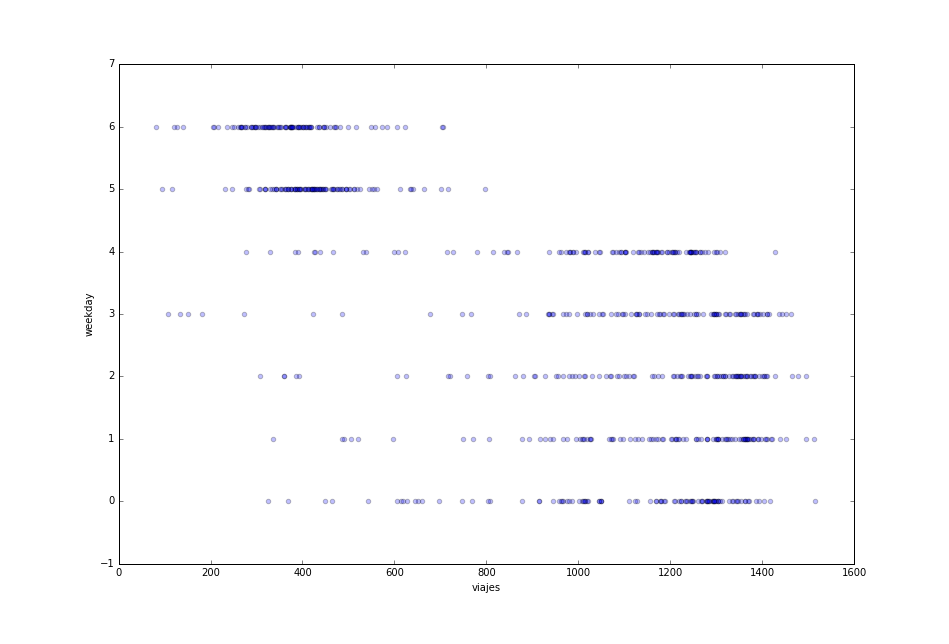

In [135]:
Turi.plot.scatter('viajes','weekday',alpha=0.25,figsize=(12,8));

In [128]:
fig, ax = plt.subplots(figsize=(16,5));        # Sample figsize in inches
cor = Turi.loc[:,['viajes','Normal','Rain','Fog']]\
        .corr().abs()
cor.values[[np.arange(4)]*2] = 0
sns.heatmap(cor,cmap='Oranges');

#MALISIMO EL GRAFICO

NameError: name 'plt' is not defined